In [1]:
# Importing packages
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

class NST:
  # The init method or constructor
  def __init__(self, content_image, style_image, img_size, STYLE_LAYERS = [], optimizer = None):
    self.content_image = content_image
    self.style_image = style_image
    self.img_size = img_size
    self.STYLE_LAYERS = STYLE_LAYERS
    self.optimizer = optimizer

  # Deleting (Calling destructor)
  def __del__(self):
      print('Destructor called, NST object is deleted.')

  # Neural Style Transfer (NST) uses a previously trained 
  # convolutional network, and builds on top of that. 
  # The idea of using a network trained on a different 
  #task and applying it to a new task is called transfer learning.
  def load_vgg_model(self):
    tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
    pp = pprint.PrettyPrinter(indent=4)
    self.img_size = 400
    vgg = tf.keras.applications.VGG19(include_top=False,
                                      input_shape=(self.img_size, self.img_size, 3),
                                      #weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
                                      weights='imagenet')
    vgg.trainable = False
    pp.pprint(vgg)
    return vgg

  # Compute_content_cost function

  def compute_content_cost(self,content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.transpose(tf.reshape(a_C, shape=[m, -1, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, shape=[m, -1, n_C]))
    
    # compute the cost with tensorflow
    J_content =  (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content

  # gram_matrix function
  # The style matrix is also called a "Gram matrix." 
  # The result is a matrix of dimension  (nC,nC) 
  # where  nC  is the number of filters (channels). The value  G(gram)i,j  
  # measures how similar the activations of filter i  
  # are to the activations of filter j.
  # By capturing the prevalence of different types of features ( G(gram)ii ), 
  # as well as how much different features occur together ( G(gram)ij ), 
  # the Style matrix  Ggram  measures the style of an image.

  def gram_matrix(self,A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)

    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  

    GA = tf.matmul(A, A, transpose_b=True)

    return GA

  # compute_layer_style_cost function

  def compute_layer_style_cost(self, a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W)
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    # Computing gram_matrices for both images S and G
    GS = self.gram_matrix(a_S)
    GG = self.gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = (1 / (4 * n_C **2 * (n_H * n_W) **2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    #J_style_layer = (1 / (4 * tf.square(n_C) * tf.square(n_H * n_W))) * (tf.reduce_sum(tf.square(tf.subtract(GS, GG))))
    return J_style_layer

# style_layers function
  def style_layers(self):
    vgg = self.load_vgg_model()
    # Listing the layer names
    for layer in vgg.layers:
      print(layer.name)
    # This is defined as the content layer, which will represent the image
    vgg.get_layer('block5_conv4').output
    STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

    self.STYLE_LAYERS = STYLE_LAYERS

  # compute_style_coset function    
  # For each layer:
  # Select the activation (the output tensor) of the current layer.
  # Get the style of the style image "S" from the current layer.
  # Get the style of the generated image "G" from the current layer.
  # Compute the "style cost" for the current layer
  # Add the weighted style cost to the overall style cost (J_style)
  def compute_style_cost(self, style_image_output, generated_image_output, STYLE_LAYERS):
      """
      Computes the overall style cost from several chosen layers
      
      Arguments:
      style_image_output -- our tensorflow model
      generated_image_output --
      STYLE_LAYERS -- A python list containing:
                          - the names of the layers we would like to extract style from
                          - a coefficient for each of them
      
      Returns: 
      J_style -- tensor representing a scalar value, style cost defined above by equation (2)
      """
      
      # initialize the overall style cost
      J_style = 0

      # Set a_S to be the hidden layer activation from the layer we have selected.
      # The last element of the array contains the content layer image, which must not to be used.
      a_S = style_image_output[:-1]

      # Set a_G to be the output of the choosen hidden layers.
      # The last element of the array contains the content layer image, which must not to be used.
      a_G = generated_image_output[:-1]
      for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
          # Compute style_cost for the current layer
          J_style_layer = self.compute_layer_style_cost(a_S[i], a_G[i])

          # Add weight * J_style_layer of this layer to overall style cost
          J_style += weight[1] * J_style_layer

      return J_style

  # total_cost function
  @tf.function()
  def total_cost(self, J_content, J_style, alpha = 10, beta = 40):
      """
      Computes the total cost function
      
      Arguments:
      J_content -- content cost coded above
      J_style -- style cost coded above
      alpha -- hyperparameter weighting the importance of the content cost
      beta -- hyperparameter weighting the importance of the style cost
      
      Returns:
      J -- total cost as defined by the formula above.
      """
      
      J = alpha * J_content + beta * J_style

      return J

  # Function which loads the VGG19 model and returns a 
  # list of the outputs for the middle layers.
  def get_layer_outputs(self, vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

  # Below are the utils that you will need to display the images generated by the style transfer model.
  def clip_0_1(self, image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

  # Below are the utils that you will need to display the images generated by the style transfer model.
  def tensor_to_image(self, tensor):
      """
      Converts the given tensor into a PIL image
      
      Arguments:
      tensor -- Tensor
      
      Returns:
      Image: A PIL image
      """
      tensor = tensor * 255
      tensor = np.array(tensor, dtype=np.uint8)
      if np.ndim(tensor) > 3:
          assert tensor.shape[0] == 1
          tensor = tensor[0]
      return Image.fromarray(tensor)
 
    
  # train_step function for transfer learning
  @tf.function()
  def train_step(self, generated_image):
    with tf.GradientTape() as tape:
          # In this function you must use the precomputed encoded images a_S and a_C
          # Compute a_G as the vgg_model_outputs for the current generated image
          
          a_G = vgg_model_outputs(generated_image)
          
          # Compute the style cost
          J_style = self.compute_style_cost(a_S, a_G, self.STYLE_LAYERS)

          # Compute the content cost
          J_content = self.compute_content_cost(a_C, a_G)
          # Compute the total cost
          J = self.total_cost(J_content, J_style)  

    grad = tape.gradient(J, generated_image)

    self.optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(self.clip_0_1(generated_image))
    return J

  # Neuro Style Transfer training function
  def nst_training(self, epochs, generated_image):
    for i in range(epochs):
      self.train_step(generated_image)
      if i % 250 == 0:
          print(f"Epoch {i} ")
      if i % 250 == 0:
          image = self.tensor_to_image(generated_image)
          imshow(image)
          image.save(f"output/image_{i}.jpg")
          plt.show()


(1, 400, 400, 3)


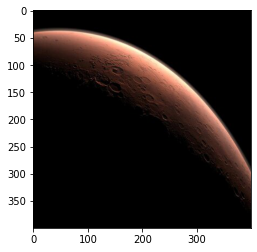

(1, 400, 400, 3)


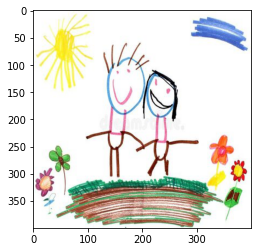

(1, 400, 400, 3)


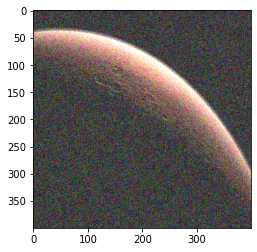

input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
tf.Tensor(0.0051207924, shape=(), dtype=float32)
tf.Tensor(1774.318, shape=(), dtype=float32)
Epoch 0 


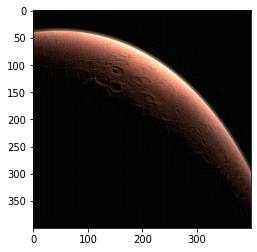

Epoch 250 


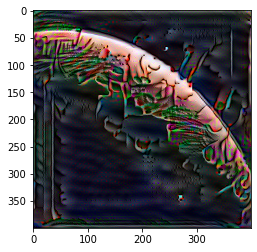

Epoch 500 


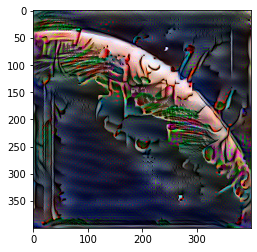

Epoch 750 


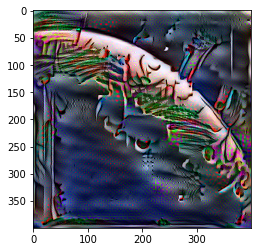

Epoch 1000 


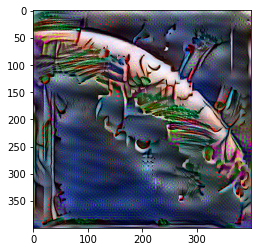

Epoch 1250 


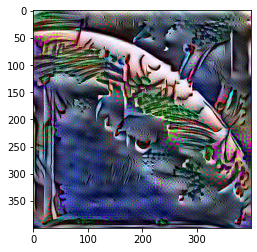

Epoch 1500 


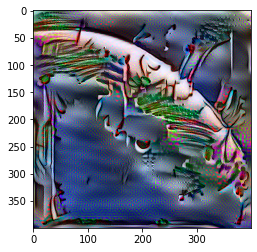

Epoch 1750 


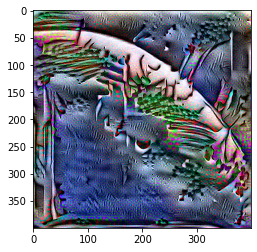

Epoch 2000 


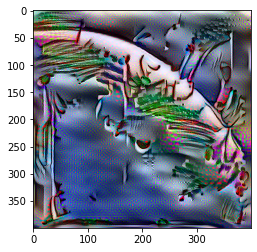

Epoch 2250 


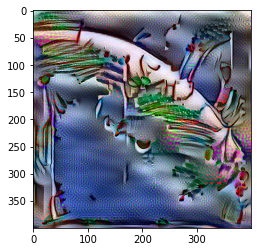

Epoch 2500 


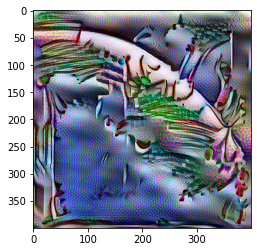

In [ ]:
# test code (Main code)

# Load content and style images
content_image = np.array(Image.open("images/nasa-400-400.jpg"))
style_image =  np.array(Image.open("images/dbaye-400-400.jpg"))
# Create an NST object
nst_object = NST(content_image = content_image, style_image = style_image,img_size = 400)
# Open and resize the content and style images
content_image = np.array(Image.open("images/nasa-400-400.jpg").resize((nst_object.img_size, nst_object.img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
style_image =  np.array(Image.open("images/dbaye-400-400.jpg").resize((nst_object.img_size, nst_object.img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

# Display content image
print(content_image.shape)
imshow(content_image[0])
plt.show()

# Display style image
print(style_image.shape)
imshow(style_image[0])
plt.show()

# Randomly Initialize the Image to be Generated
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

# Display the noisy generated image
print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

content_layer = [('block5_conv4', 1)]
nst_object.style_layers()
vgg_model_outputs = nst_object.get_layer_outputs(nst_object.load_vgg_model(), nst_object.STYLE_LAYERS + content_layer)

# Save the outputs for the content and style layers in separate variables.
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = nst_object.compute_content_cost(a_C, a_G)

print(J_content)

# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = nst_object.compute_style_cost(a_S, a_G, nst_object.STYLE_LAYERS)
print(J_style)

generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

nst_object.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.03)

# Show the generated image at some epochs
# Uncoment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 2501
nst_object.nst_training(epochs, generated_image) 